<a href="https://colab.research.google.com/github/gonzaq94/llm_tutorials/blob/master/notebooks/4_evaluation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Evaluating Finetuned Model

In this section, we demonstrate how to evaluate the previously finetuned model.

In [2]:
! pip install transformers comet-llm comet-ml sentencepiece --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.2/73.2 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 687.3/687.3 kB 18.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 979.1/979.1 kB 43.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 75.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.5/54.5 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 309.1/309.1 kB 18.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 137.9/137.9 kB 10.0 MB/s eta 0:00:00


In [3]:
import os
from transformers import AutoModelForCausalLM
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM, Seq2SeqTrainingArguments, Seq2SeqTrainer
import transformers
import pandas as pd
import comet_llm

COMET_WORKSPACE = "gonzaq94"
COMET_API_KEY = "70hdKpWAXsGBl956kbVxML85N"

transformers.set_seed(35)

### Load the Finetuned Model

The first step is to load the finetuned model. You can load the model different ways, but in this example, we download our model and tokenizer from Comet (we stored them there in the last assignment), and then use Huggingface's Transformers library  to load the pretrained model and tokenizer.

In [6]:
# Download model from registry:

from comet_ml import API

api = API(api_key=COMET_API_KEY)

# model name
model_name = "Emotion-T5-Base"

#get the Model object
model = api.get_model(workspace=COMET_WORKSPACE, model_name=model_name)

# Download a Registry Model:
model.download("1.0.0", "./deploy", expand=True)

COMET INFO: Remote Model 'gonzaq94/Emotion-T5-Base:1.0.0' download has been started asynchronously.
COMET INFO: Still downloading 12 file(s), remaining 2.77 GB/2.77 GB
COMET INFO: Still downloading 2 file(s), remaining 2.12 GB/2.77 GB, Throughput 44.30 MB/s, ETA ~49s
COMET INFO: Still downloading 2 file(s), remaining 1.43 GB/2.77 GB, Throughput 46.74 MB/s, ETA ~32s
COMET INFO: Still downloading 1 file(s), remaining 836.10 MB/2.77 GB, Throughput 41.98 MB/s, ETA ~20s
COMET INFO: Still downloading 1 file(s), remaining 465.10 MB/2.77 GB, Throughput 24.70 MB/s, ETA ~19s
COMET INFO: Still downloading 1 file(s), remaining 155.10 MB/2.77 GB, Throughput 20.64 MB/s, ETA ~8s
COMET INFO: Remote Model 'gonzaq94/Emotion-T5-Base:1.0.0' has been successfully downloaded.
COMET INFO: Downloaded asset files is in './deploy' folder.


The `model.download()` method will download not only the model file, but all the related assets we logged, meaning we can point Huggingface's `from_pretrained()` method directly at our download folder and everything will just work.

In [7]:
# load model and tokenizer
model = AutoModelForSeq2SeqLM.from_pretrained("./deploy/checkpoint-7")
tokenizer = AutoTokenizer.from_pretrained("./deploy/checkpoint-7/")

You set `add_prefix_space`. The tokenizer needs to be converted from the slow tokenizers


### Load the Data to Evaluate

The next step is to load the evaluation dataset. We are reloading the dataset from the previous notebook.

In [8]:
emotion_dataset_val_temp = pd.read_json(path_or_buf="https://raw.githubusercontent.com/comet-ml/comet-llmops/main/data/merged_training_sample_prepared_valid.jsonl", lines=True)
emotion_dataset_test = emotion_dataset_val_temp.iloc[int(len(emotion_dataset_val_temp)/2):]

In [9]:
emotion_dataset_test.head().prompt.tolist()

['i feel very very disturbed right now i dont know how to say this but guess i couldnt sleep tonight just to think about this about him\n\n###\n\n',
 'i feel make them the most dangerous and their level of annoyance is what gives them high priority\n\n###\n\n',
 'i can feel sympathetic joy for my boyfriend and colleagues the latter being like times harder than the former\n\n###\n\n',
 'i found these emails from scott dale and just reading them frusterated me so much that i feel the need to post them and show the world what a neurotic freak he was is\n\n###\n\n',
 'i won t lie and say there isn t a part of me that still feels insulted by it\n\n###\n\n']

### Evaluate Finetuned Emotion Classifier

Evaluate different models and prompting techniques and log results when prompting the fine-tuned model. As a take-how exercise feel free to log results with few-shot and one-shot prompting using gpt-3.5-turbo. This way it will be possible to compare the finetuned model with other high-performing models.


In [10]:
from transformers import LogitsProcessorList, MinLengthLogitsProcessor

class CustomLogitsProcessor(LogitsProcessorList):
    def __init__(self, allowed_tokens):
        super().__init__()
        self.allowed_tokens = allowed_tokens

    def process(self, logits, scores, **kwargs):
        # Set probabilities of non-allowed tokens to 0
        for i in range(logits.size(-1)):
            if i not in self.allowed_tokens:
                logits[:, i] = -float('Inf')
        return logits

# Define allowed tokens (this will need to be matched to your tokenizer's vocab)
allowed_tokens = tokenizer.convert_tokens_to_ids(['anger', 'fear', 'joy', 'love', 'sadness', 'surprise'])
custom_processor = CustomLogitsProcessor(allowed_tokens)

In [42]:
def get_logit_for_words(logits_tensor, words_of_interest, tokenizer):
    """
    Extracts the logits for specified words from a logits tensor.

    Args:
    - logits_tensor (torch.Tensor): Tensor of shape [batch_size, sequence_length, vocab_size].
    - words_of_interest (list of str): List of words for which logits are needed.
    - tokenizer (AutoTokenizer): Tokenizer used to convert words to token IDs.

    Returns:
    - dict: A dictionary with words as keys and their corresponding logits as values.
    """
    # Convert words to token IDs
    token_ids = [tokenizer.encode(word, add_special_tokens=False)[0] for word in words_of_interest]

    # Ensure logits_tensor is a 3D tensor with shape [batch_size, sequence_length, vocab_size]
    if logits_tensor.dim() != 3:
        raise ValueError("Logits tensor must be 3-dimensional with shape [batch_size, sequence_length, vocab_size].")

    # Extract logits for specific token IDs
    # Assuming logits_tensor is for a single sequence (batch_size=1)
    # Modify indexing if batch_size > 1 or if using a different format
    batch_size, sequence_length, vocab_size = logits_tensor.shape
    logits_for_interest = logits_tensor[0, :, token_ids]  # [sequence_length, len(words_of_interest)]

    # Create a dictionary to hold the logits for the words of interest
    logits_dict = {word: logits_for_interest[:, i].tolist() for i, word in enumerate(words_of_interest)}

    return logits_dict


In [73]:
import torch

# for comet logging
comet_llm.init(project="emotion-evaluation-run2")

# prompt prefix
prefix = "Classify the provided piece of text into one of the following emotion labels.\n\nEmotion labels: ['anger', 'fear', 'joy', 'love', 'sadness', 'surprise']. \n\nText:"

# prepare prompts
prompts = [{"prompt": row.prompt.strip("\n\n###\n\n") + "\n\n" + "Emotion output:", "completion": row.completion.strip("\n").strip(" ")} for index, row in emotion_dataset_test.iterrows()]

# expected results to log
actual_completions = [prompt["completion"] for prompt in prompts]

# the results from the fine-tuned model
finetuned_completions = []
temperature = 0.1

for idx, prompt in enumerate(prompts):

    #####
    # finetuned model outputs
    input_ids = tokenizer.encode(prefix + prompt["prompt"], return_tensors="pt")
    output = model.generate(input_ids, do_sample=True, max_new_tokens=1, temperature=0.2, return_dict=True)

    #output_text = tokenizer.decode(output[0], skip_special_tokens=True).strip("<pad>").strip(" ")
    output_text = tokenizer.decode(output[0], skip_special_tokens=True)
    if output_text == "Emotion":
        print(idx, prefix + prompt["prompt"], output_text, output)
    finetuned_completions.append(output_text)

    # log the prompts
    comet_llm.log_prompt(
        prompt = prefix + prompt["prompt"],
        tags = ["flan-t5-base", "fine-tuned"],
        metadata = {
            "model_name": "flan-t5-base",
            "temperature": temperature,
            "expected_output": prompt["completion"],
        },
        output = output_text
    )

    # exercise: log zero-shot and few-shot results with GPT-3.5-Turbo and GPT-4 and compare with your fine-tuned model
    ### zero-shot GPT-3.5-Turbo


Prompt logged to https://www.comet.com/gonzaq94/emotion-evaluation-run2


INFO:comet_llm.summary:Prompt logged to https://www.comet.com/gonzaq94/emotion-evaluation-run2


# BART large inference

In [132]:
sequence_to_classify = "one day I will see the world"
candidate_labels = ['cooking', 'travel', 'dancing']
classifier(sequence_to_classify, candidate_labels)

{'sequence': 'one day I will see the world',
 'labels': ['travel', 'dancing', 'cooking'],
 'scores': [0.9938650727272034, 0.0032737923320382833, 0.0028610334265977144]}

In [134]:
from transformers import AutoModelForSequenceClassification, AutoTokenizer, pipeline
import numpy as np

# Load pre-trained model and tokenizer
model_name = 'facebook/bart-large-mnli'  # or 'gpt2-medium', 'gpt2-large', 'gpt2-xl'

tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)

tokenizer.pad_token = tokenizer.eos_token

classifier = pipeline("zero-shot-classification", model="facebook/bart-large-mnli")

# for comet logging
comet_llm.init(project="emotion-evaluation-bart-zero-shot")

# prompt prefix
prefix = "Classify the provided piece of text into one of the following emotion labels.\n\nEmotion labels: ['anger', 'fear', 'joy', 'love', 'sadness', 'surprise']. \n\nText:"

# candidate labels
candidate_labels = ['anger', 'fear', 'joy', 'love', 'sadness', 'surprise']

# prepare prompts
prompts = [{"prompt": row.prompt.strip("\n\n###\n\n"), "completion": row.completion.strip("\n").strip(" ")} for index, row in emotion_dataset_test.iterrows()]

# expected results to log
actual_completions = [prompt["completion"] for prompt in prompts]


In [136]:
# the results from the fine-tuned model
bart_zero_shot_completions = []
for idx, prompt in enumerate(prompts):

    input_ids = tokenizer.encode(prompt["prompt"], return_tensors="pt")
    # Perform zero-shot classification
    result = classifier(prompt["prompt"], candidate_labels)

    output_text = result['labels'][0]
    bart_zero_shot_completions.append(output_text)

    # log the prompts
    comet_llm.log_prompt(
        prompt = prefix + prompt["prompt"],
        tags = [model_name, "zero-shot"],
        metadata = {
            "model_name": model_name,
            "expected_output": prompt["completion"],
        },
        output = output_text
    )


# BART with few-shot classification

In [158]:
from transformers import AutoModelForSequenceClassification, AutoTokenizer, pipeline
import numpy as np

# Load pre-trained model and tokenizer
model_name = 'facebook/bart-large-mnli'
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)

# Set tokenizer pad token
tokenizer.pad_token = tokenizer.eos_token

# Initialize the classifier pipeline
classifier = pipeline("zero-shot-classification", model=model_name)

# for comet logging
comet_llm.init(project="emotion-evaluation-bart-few-shot")

# Define your candidate emotion labels
candidate_labels = ['anger', 'fear', 'joy', 'love', 'sadness', 'surprise']
candidate_labels = ['fear', 'joy', 'love', 'sadness', 'anger', 'surprise']


# Define few-shot examples
few_shot_examples = [
    {"text": "I can't believe this happened, I'm so angry!", "label": "anger"},
    {"text": "I'm feeling nervous about tomorrow.", "label": "fear"},
    {"text": "I just got a promotion and I’m thrilled!", "label": "joy"},
    {"text": "I love spending time with my family.", "label": "love"},
    {"text": "I feel so down and sad.", "label": "sadness"},
    {"text": "Wow, that was unexpected!", "label": "surprise"},
]

# Function to create few-shot prompt by appending examples to the input prompt
def create_few_shot_prompt(prompt, few_shot_examples):
    few_shot_prompt = ""
    for example in few_shot_examples:
        few_shot_prompt += f"Text: {example['text']}\nLabel: {example['label']}\n\n"
    few_shot_prompt += f"Text: {prompt}\nLabel:"
    return few_shot_prompt

# Prepare prompts
prompts = [{"prompt": row.prompt.strip("\n\n###\n\n"),
            "completion": row.completion.strip("\n").strip(" ")} for index, row in emotion_dataset_test.iterrows()]

# For storing the results
bart_few_shot_completions = []

# Loop through prompts and perform few-shot classification
for idx, prompt in enumerate(prompts):
    # Create the few-shot prompt by including labeled examples
    few_shot_prompt = create_few_shot_prompt(prompt["prompt"], few_shot_examples)
    #few_shot_prompt = prompt["prompt"]

    # Perform classification
    result = classifier(few_shot_prompt, candidate_labels)
    print(result['labels'])

    output_text = result['labels'][0]
    # Save the output
    bart_few_shot_completions.append(output_text)

    # Log the prompts
    comet_llm.log_prompt(
        prompt = prefix + prompt["prompt"],
        tags = [model_name, "few-shot"],
        metadata = {
            "model_name": model_name,
            "expected_output": prompt["completion"],
        },
        output = output_text
    )

['anger', 'sadness', 'fear', 'surprise', 'love', 'joy']
['anger', 'sadness', 'surprise', 'fear', 'joy', 'love']


KeyboardInterrupt: 

In [153]:
bart_few_shot_completions

['anger',
 'anger',
 'anger',
 'anger',
 'anger',
 'anger',
 'anger',
 'anger',
 'anger',
 'anger',
 'anger',
 'anger',
 'anger',
 'anger',
 'anger',
 'anger',
 'anger',
 'anger',
 'anger',
 'anger',
 'anger',
 'anger',
 'anger',
 'anger',
 'anger',
 'anger',
 'anger',
 'anger',
 'anger',
 'anger',
 'anger',
 'anger',
 'anger',
 'anger',
 'anger',
 'anger',
 'anger',
 'anger',
 'anger',
 'anger',
 'anger',
 'anger',
 'anger',
 'anger',
 'anger',
 'anger',
 'anger',
 'anger',
 'anger',
 'anger',
 'anger',
 'anger',
 'anger',
 'anger',
 'anger',
 'anger',
 'anger',
 'anger',
 'anger',
 'anger']

### Finetuned Model - Confusion Matrix

Prepare a confusion matrix to better understand the performance of the fine-tuned model on the multi-label classification task.

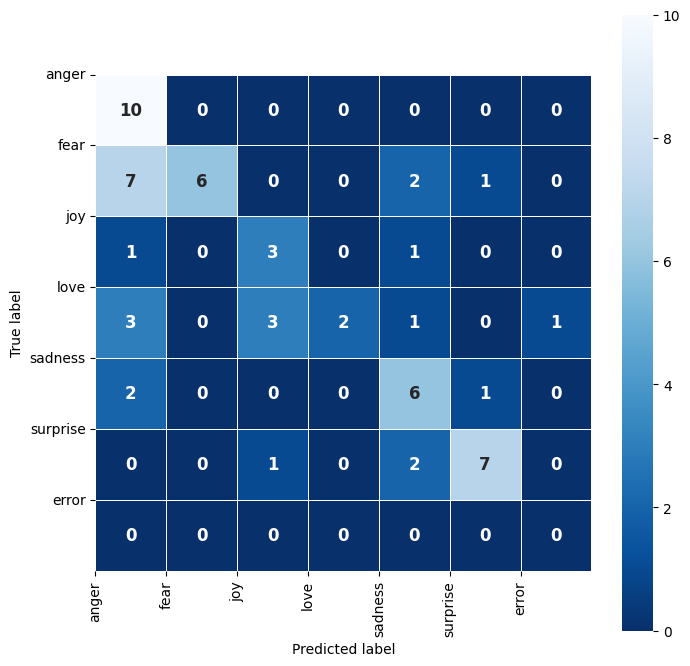

Accuracy 0.5666666666666667


In [150]:
# confusion matrix (logged to experiments as well)

from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# map completion labels to integers
completion_map = {
    "anger": 0,
    "fear": 1,
    "joy": 2,
    "love": 3,
    "sadness": 4,
    "surprise": 5,
    "error": 6
}

# mapper back to string labels
completion_map_string = {
    0: "anger",
    1: "fear",
    2: "joy",
    3: "love",
    4: "sadness",
    5: "surprise",
    6: "error"
}

# Convert completions to integers
actual_completions_int = [completion_map[completion] for completion in actual_completions]
finetuned_completions_int = [6 if completion == "E" else completion_map[completion] for completion in finetuned_completions]

# Compute confusion matrix
cm = confusion_matrix(actual_completions_int, finetuned_completions_int)

# Plot confusion matrix
plt.figure(figsize=(8, 8))
sns.heatmap(cm, annot=True, fmt=".0f", linewidths=0.5, square=True, cmap="Blues_r",
            annot_kws={"size": 12, "weight": 'bold', "ha": 'center', "va": 'center'})

# Add emotion labels to confusion matrix
plt.ylabel("True label")
plt.xlabel("Predicted label")

# Annotate the confusion matrix with completion labels
tick_marks = [i for i in range(len(completion_map_string))]
plt.xticks(tick_marks, list(completion_map_string.values()), rotation="vertical")
plt.yticks(tick_marks, list(completion_map_string.values()), rotation="horizontal")

plt.show()

# calculate accuracy
acc = (np.array(actual_completions_int) == np.array(finetuned_completions_int)).sum() / len(actual_completions_int)
print(f"Accuracy {acc}")

### BART-lare confusion matrix (zero-shot)





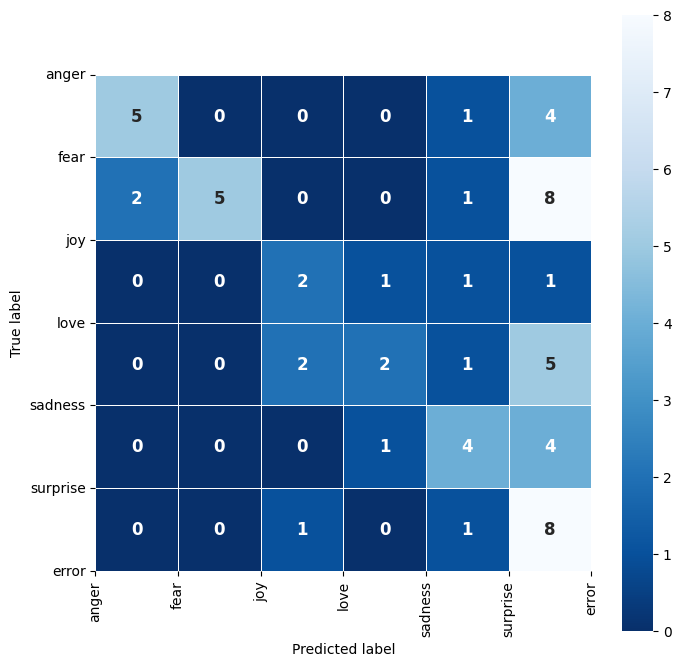

Accuracy 0.43333333333333335


In [148]:
# confusion matrix (logged to experiments as well)

from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# map completion labels to integers
completion_map = {
    "anger": 0,
    "fear": 1,
    "joy": 2,
    "love": 3,
    "sadness": 4,
    "surprise": 5,
    "error": 6
}

# mapper back to string labels
completion_map_string = {
    0: "anger",
    1: "fear",
    2: "joy",
    3: "love",
    4: "sadness",
    5: "surprise",
    6: "error"
}

# Convert completions to integers
actual_completions_int = [completion_map[completion] for completion in actual_completions]
bart_zero_shot_completions_int = [6 if completion not in completion_map.keys() else completion_map[completion] for completion in bart_zero_shot_completions]

# Compute confusion matrix
cm = confusion_matrix(actual_completions_int, bart_zero_shot_completions_int)

# Plot confusion matrix
plt.figure(figsize=(8, 8))
sns.heatmap(cm, annot=True, fmt=".0f", linewidths=0.5, square=True, cmap="Blues_r",
            annot_kws={"size": 12, "weight": 'bold', "ha": 'center', "va": 'center'})

# Add emotion labels to confusion matrix
plt.ylabel("True label")
plt.xlabel("Predicted label")

# Annotate the confusion matrix with completion labels
tick_marks = [i for i in range(len(completion_map_string))]
plt.xticks(tick_marks, list(completion_map_string.values()), rotation="vertical")
plt.yticks(tick_marks, list(completion_map_string.values()), rotation="horizontal")

plt.show()

# calculate accuracy
acc = (np.array(actual_completions_int) == np.array(bart_zero_shot_completions_int)).sum() / len(actual_completions_int)
print(f"Accuracy {acc}")

### BART-lare confusion matrix (few-shot)

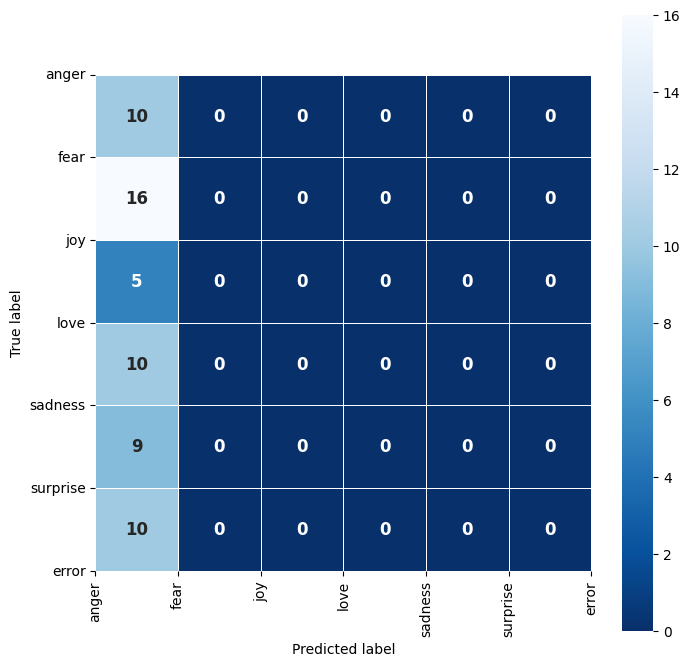

Accuracy 0.16666666666666666


In [152]:
# confusion matrix (logged to experiments as well)

from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# map completion labels to integers
completion_map = {
    "anger": 0,
    "fear": 1,
    "joy": 2,
    "love": 3,
    "sadness": 4,
    "surprise": 5,
    "error": 6
}

# mapper back to string labels
completion_map_string = {
    0: "anger",
    1: "fear",
    2: "joy",
    3: "love",
    4: "sadness",
    5: "surprise",
    6: "error"
}

# Convert completions to integers
actual_completions_int = [completion_map[completion] for completion in actual_completions]
bart_few_shot_completions_int = [6 if completion not in completion_map.keys() else completion_map[completion] for completion in bart_few_shot_completions]

# Compute confusion matrix
cm = confusion_matrix(actual_completions_int, bart_few_shot_completions_int)

# Plot confusion matrix
plt.figure(figsize=(8, 8))
sns.heatmap(cm, annot=True, fmt=".0f", linewidths=0.5, square=True, cmap="Blues_r",
            annot_kws={"size": 12, "weight": 'bold', "ha": 'center', "va": 'center'})

# Add emotion labels to confusion matrix
plt.ylabel("True label")
plt.xlabel("Predicted label")

# Annotate the confusion matrix with completion labels
tick_marks = [i for i in range(len(completion_map_string))]
plt.xticks(tick_marks, list(completion_map_string.values()), rotation="vertical")
plt.yticks(tick_marks, list(completion_map_string.values()), rotation="horizontal")

plt.show()

# calculate accuracy
acc = (np.array(actual_completions_int) == np.array(bart_few_shot_completions_int)).sum() / len(actual_completions_int)
print(f"Accuracy {acc}")

### Saving Confusion Matrix

The code below saves the confusion matrix to the selected Comet experiment. You can obtained the experiment key from Comet's experiment dashboard.

Make sure to change the experiment key to your own experiment key. Refer to the video lecture or [Comet's documentation](https://www.comet.com/docs/v2/api-and-sdk/python-sdk/reference/ExistingExperiment/#existingexperimentlog_code) for how to locate the experiment key for your experiment.

In [ ]:
from comet_ml import ExistingExperiment

experiment = ExistingExperiment(api_key=COMET_API_KEY, previous_experiment="097ab78e6e154f24b8090a1a7dd6abb8")
experiment.log_confusion_matrix(actual_completions_int, finetuned_completions_int, labels=list(completion_map_string.values()))

COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


COMET INFO: Experiment is live on comet.com https://www.comet.com/omarsar/emotion-classification/097ab78e6e154f24b8090a1a7dd6abb8



{'web': 'https://www.comet.com/api/asset/download?assetId=9f5b04f8cc7441bcb39b27de799fb2ed&experimentKey=097ab78e6e154f24b8090a1a7dd6abb8',
 'api': 'https://www.comet.com/api/rest/v2/experiment/asset/get-asset?assetId=9f5b04f8cc7441bcb39b27de799fb2ed&experimentKey=097ab78e6e154f24b8090a1a7dd6abb8',
 'assetId': '9f5b04f8cc7441bcb39b27de799fb2ed'}